<a href="https://colab.research.google.com/github/q-viper/Artistic-Neural-Style-Transfer/blob/master/Artisitic_Neural_Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copied from Medium article : https://medium.com/gradientcrescent/neural-art-style-transfer-with-keras-theory-and-implementation-91b7fb08ee81

During NST, we define two losses in order to preserve both the content of the target image and the style of the reference image. The loss function is a weighted sum of the content loss and style loss which is minimized using gradient descent. Intuitively, we are iteratively updating our output image in such a way that it minimizes our total loss by bringing the output as close as possible to the content of the target image and the style of the reference image.

So how do we define content and style losses? Recall that during image classification, a neural network’s earlier layers captures the lower-level features, with later layers focusing on identifying more complex patterns, with the eventual aim of producing a classification output.
We hence define content loss simply as the L2 distance between the intermediate content representations , taken from higher (later) layers of a pre-trained neural network, for a input image and the target image. As a high level layer produces filters that possess complex raw information for the input image, this is a suitable approximation for judging similarity in terms of content.

Similarly, we define the style loss as the L2 distance between the gram matrices of the intermediate style representations for the style image (taken from lower layers of a pre-trained neural network) and the output images. The lower level layers capture more simple image features which best encode the concept of style. Intuitively, Gram matrices we distribute and delocalize spatial information in an image and approximate the “style” of an image. Mathematically, they are matrices are simply multiplication of the image matrix and its transpose.

Finally, we add a third loss value known as the total variation loss (TVL) . While not seen in the original paper, TVL was introduced in a paper by Mahendran and Vedaldi in 2015 with the aim to encourage image consistency and special continuity, minimizing pixilation and sharp feature formation. TVL works by penalizing larger gradients during the transfer process, distributing overall changes across larger regions rather than concentrating them at points or curves, ensuring a smoother image at the expense of image sharpness.
To conclude, by summing up and minimizing all three aforementioned losses, we generate an output image that best matches the content of our target image, while adopting the new style from the reference image.

In [0]:
# from keras import backend as K 
# inp = model.input                                           # input placeholder
# outputs = [layer.output for layer in model.layers][1:]        # all layer outputs except first (input) layer
# functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

# # Testing
# test = np.random.random([224, 224, 3])[np.newaxis,...]
# layer_outs = functor([test, 1.])
# l1 = layer_outs[2]


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
target_image_path = 'drive/My Drive/ANST/assets/pp.jpg'
reference_image_path = 'drive/My Drive/ANST/assets/nst9.jpg'
width, height = load_img(target_image_path).size
img_height = 800
img_width = int(width * img_height / height)

In [0]:
import numpy as np
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img
def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
from keras.applications import vgg19
target_image = K.constant(preprocess_image(target_image_path))
reference_image = K.constant(preprocess_image(reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_image,
                              reference_image,
                              combination_image], axis=0)
    
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
def total_variation_loss(x):
    a = K.square(
            x[:, :img_height - 1, :img_width - 1, :] -
            x[:, 1:, :img_width - 1, :])
    b = K.square(
            x[:, :img_height - 1, :img_width - 1, :] -
            x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-5
style_weight = 1.
content_weight = 0.0003125

In [55]:
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    
    reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    sl = style_loss(reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

W0805 16:47:46.705721 140528930613120 variables.py:2429] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

Start of iteration 0
Current loss value: 509706980.0


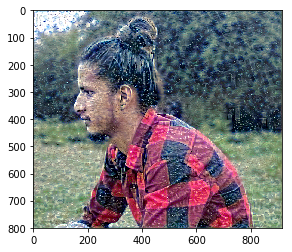

Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 60s
Start of iteration 1
Current loss value: 213501390.0


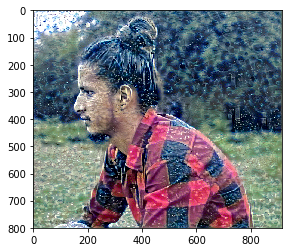

Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 59s
Start of iteration 2
Current loss value: 125829010.0


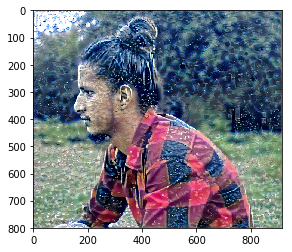

Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 60s
Start of iteration 3
Current loss value: 88709390.0


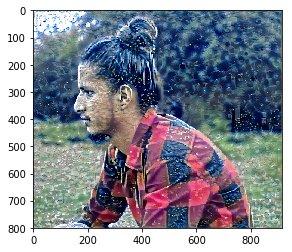

Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 61s
Start of iteration 4
Current loss value: 68649976.0


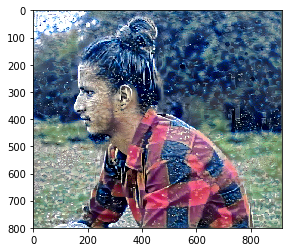

Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 62s
Start of iteration 5
Current loss value: 57232268.0


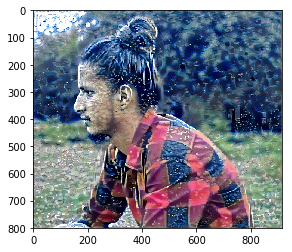

Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 61s
Start of iteration 6
Current loss value: 48975950.0


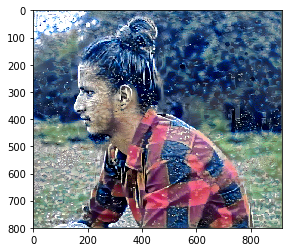

Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 62s
Start of iteration 7
Current loss value: 43231916.0


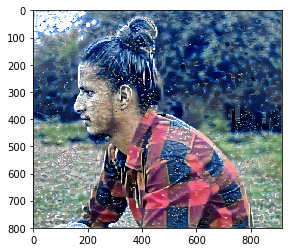

Image saved as my_result_at_iteration_7.png
Iteration 7 completed in 61s
Start of iteration 8
Current loss value: 38967652.0


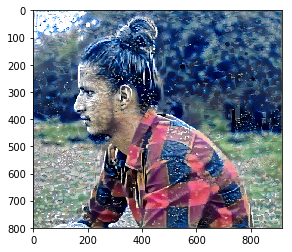

Image saved as my_result_at_iteration_8.png
Iteration 8 completed in 62s
Start of iteration 9
Current loss value: 35122150.0


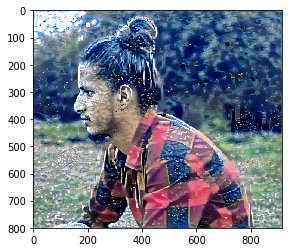

Image saved as my_result_at_iteration_9.png
Iteration 9 completed in 62s
Start of iteration 10
Current loss value: 32278012.0


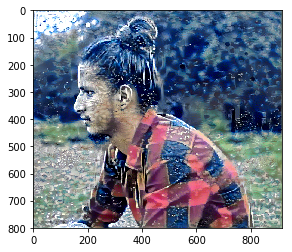

Image saved as my_result_at_iteration_10.png
Iteration 10 completed in 62s
Start of iteration 11
Current loss value: 29918632.0


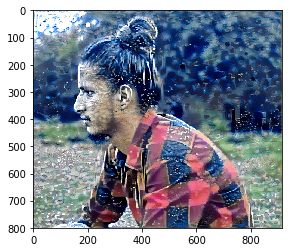

Image saved as my_result_at_iteration_11.png
Iteration 11 completed in 62s
Start of iteration 12
Current loss value: 28072532.0


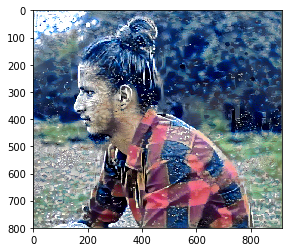

Image saved as my_result_at_iteration_12.png
Iteration 12 completed in 62s
Start of iteration 13
Current loss value: 26423892.0


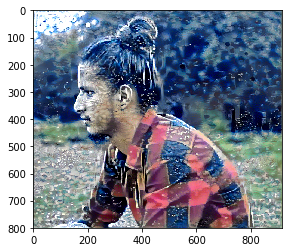

Image saved as my_result_at_iteration_13.png
Iteration 13 completed in 62s
Start of iteration 14
Current loss value: 25003960.0


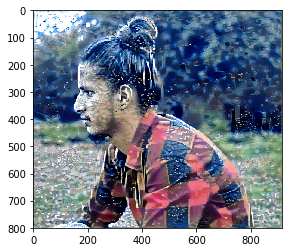

Image saved as my_result_at_iteration_14.png
Iteration 14 completed in 61s
Start of iteration 15
Current loss value: 23699578.0


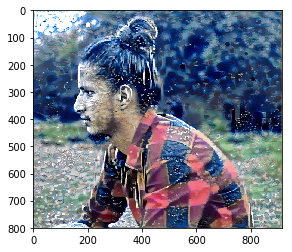

Image saved as my_result_at_iteration_15.png
Iteration 15 completed in 61s
Start of iteration 16
Current loss value: 22424316.0


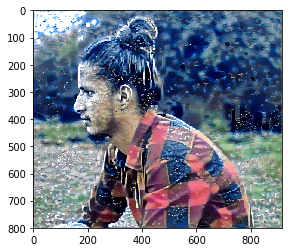

Image saved as my_result_at_iteration_16.png
Iteration 16 completed in 62s
Start of iteration 17
Current loss value: 21254438.0


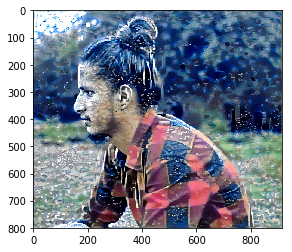

Image saved as my_result_at_iteration_17.png
Iteration 17 completed in 62s
Start of iteration 18
Current loss value: 20153808.0


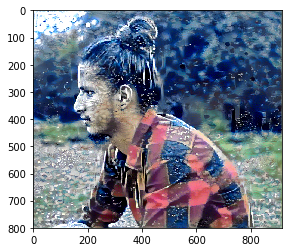

Image saved as my_result_at_iteration_18.png
Iteration 18 completed in 62s
Start of iteration 19
Current loss value: 19126936.0


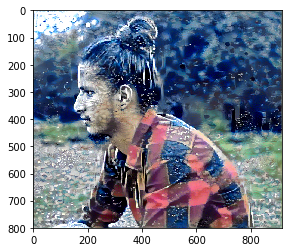

Image saved as my_result_at_iteration_19.png
Iteration 19 completed in 62s


In [57]:
import imageio
import matplotlib.pyplot as plt

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grads_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
    
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator = Evaluator()

from scipy.optimize import fmin_l_bfgs_b
# from scipy.misc import imsave
import time

result_prefix = 'my_result'
iterations = 20
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    
    
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun = 50
                                     )
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))  
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    
    plt.imshow(img)
    plt.show()
    
    print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))